# Quantization Analysis Notebook

## Import modules 

In [37]:
import numpy as np
import torch
import gif
import matplotlib.pyplot as plt
import pytorch_lightning as pl 
from pathlib import Path
import yaml
import matplotlib.ticker as ticker
import matplotlib.colors as colors

from core.autoencoder import AutoEncoder
from core.structured_data import GridDataModule

## Define and load the model/data to analyze here
You'll need to specify the yaml which created the model and the folder which contains the checkpoints for the model (this will switch to just the checkpoints in the future)

In [38]:
#### Change the entries here to analyze a new model / dataset
experiment_name = 'ignition_maxskip_cnn'
model_checkpoint_path = Path('C:\\Users\\Kevin\\Google Drive\\Research\QuadConv\\lightning_logs\\ignition_maxskip_cnn\\version_5') / 'checkpoints'
input_shape = (1,1,50,50)
###################

checkpoint = list(model_checkpoint_path.glob('epoch=*.ckpt'))

print(f'Loading experiment {experiment_name} and {checkpoint[0]} ')

experiment_path = Path('../experiments/')
model_yml = list(experiment_path.rglob(experiment_name + '*'))

with model_yml[0].open() as file:
    config = yaml.safe_load(file)

data_module = GridDataModule(**config['data'])
data_module.setup(stage='analyze')
dataset = data_module.analyze_data()

#TODO Make a dataloader option that outputs 1 experiments worth of data

model = AutoEncoder.load_from_checkpoint(checkpoint[0], input_shape=input_shape, **config['model'])
model.eval()
model.to('cpu')

Loading experiment ignition_maxskip_cnn and C:\Users\Kevin\Google Drive\Research\QuadConv\lightning_logs\ignition_maxskip_cnn\version_5\checkpoints\epoch=4467.ckpt 


AutoEncoder(
  (loss_fn): SobolevLoss()
  (output_activation): Tanh()
  (encoder): Encoder(
    (activation1): CELU(alpha=1.0)
    (activation2): CELU(alpha=1.0)
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): PoolConvBlock(
        (resample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (batchnorm1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation1): CELU(alpha=1.0)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (batchnorm2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation2): CELU(alpha=1.0)
      )
    )
    (flat): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): ParametrizedLinear(
        in_features=10000, out_feature

## Make and display the GIF associated with the dimension of the data

#### Define relavent functions for GIF making


In [39]:

@gif.frame
def plot1d(d):
    plt.plot(d)
    plt.ylim(-1,1)

@gif.frame
def plot2d(d,vmin=-1,vmax=1):
    plt.imshow(d, vmin=vmin, vmax=vmax, origin='lower')
    plt.colorbar(location='top')

def save_gif(data,original_spatial_shape, gif_save_path, gif_name,vmin=-1,vmax=1):

    save_string = str((gif_save_path / gif_name).resolve())

    if data_module.spatial_dim == 1:

        frames = [plot1d(data[i,0,:].reshape(-1,1) ) for i in range(data.shape[0])]

    elif data_module.spatial_dim == 2:

        frames = [plot2d(data[i,0,:].reshape(*original_spatial_shape),vmin,vmax) for i in range(data.shape[0])]

    gif.save(frames, save_string , duration=50)


#### Load and manipulate data

In [40]:

save_path = model_checkpoint_path / '..' 

original_spatial_shape = data_module.original_shape[1:3]

processed_data = model(dataset).detach().numpy()

difference_norm = torch.sqrt((dataset - processed_data)**2)

relative_difference_norm = difference_norm / torch.sqrt((dataset)**2)

## Quantization Tests

In [46]:
compressed_data = model.compress(dataset)

quantized_compressed_data = compressed_data.half().float()

quantized_processed_data = model.decompress(quantized_compressed_data).detach().numpy()

quantized_difference_norm = torch.sqrt((dataset - quantized_processed_data)**2)

quantized_relative_difference_norm = quantized_difference_norm / torch.sqrt((dataset)**2)


In [47]:
save_gif(quantized_processed_data,original_spatial_shape,save_path,'quantized_processed.gif')
save_gif(quantized_difference_norm,original_spatial_shape,save_path,'quantized_processed_difference.gif', vmin=0, vmax=2)

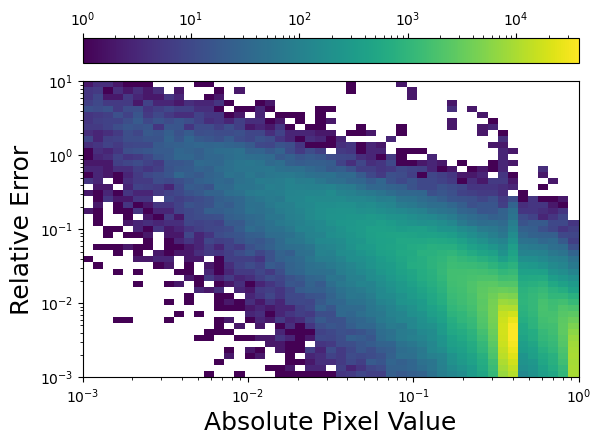

In [48]:
%matplotlib inline

xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

plt.hist2d( torch.abs(dataset.flatten()).numpy(), quantized_relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm())

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.colorbar(location='top')
plt.xlabel('Absolute Pixel Value', fontsize=18)
plt.ylabel('Relative Error', fontsize=18)

plt.savefig(save_path / 'quantized_abs_rel_histogram.png', dpi = 300)

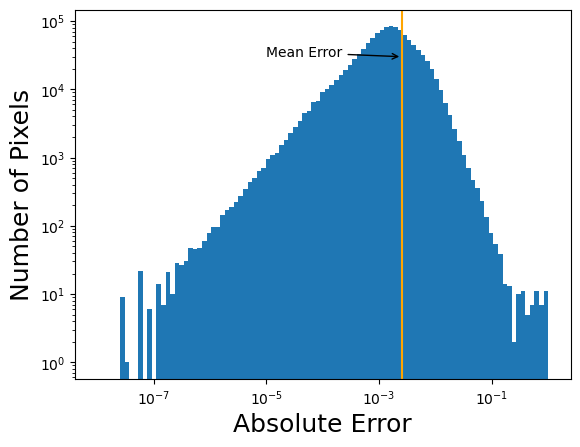

In [49]:
%matplotlib inline

plt.hist(quantized_difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=True)
plt.gca().set_xscale("log")
plt.ylabel('Number of Pixels', fontsize=18)
plt.xlabel('Absolute Error', fontsize=18)

plt.axvline(x = torch.mean(quantized_difference_norm), color = 'orange', label = 'Mean Error')
plt.annotate('Mean Error' , (torch.mean(quantized_difference_norm),3e4), xytext=(1e-5, 3e4), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

plt.savefig(save_path / 'quantized_abs_error_histogram.png', dpi = 300)